# Weekly demand-prediction with perturbed prices

## Model and training
- `wm_yr_wk`: 11130 - 11612 (d_1 - d_1911)
- Data shape
    - \# of dense columns: 12
    - \# of cat columns: 5
- Data split
    - train: `wm_yr_wk` 11130 - 11604
    - valid: `wm_yr_wk` 11605 - 11608 (4 weeks)
    - test: `wm_yr_wk` 11609 - 11612 (4 weeks)
    

In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import gc
import os
import importlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import utils

datapath = 'data'
corr_threshold = -0.3
weekly_filename = 'week_diff_price_demand_corr{}.csv'.format(corr_threshold)

df_input = pd.read_csv(os.path.join(datapath, weekly_filename), index_col=0)
df_input.head()

week_dense_cols = ['week_sell_price', 'diff_week_price', 'week_sell_price_rel_diff', 'week_sell_price_roll_sd7', 'week_sell_price_cumrel', 
                   'week_lag_t28', 'week_rolling_mean_t7', 'week_rolling_mean_t30', 'week_rolling_mean_t60', 'week_rolling_mean_t90', 'week_rolling_mean_t180', 
                   'week_rolling_std_t7', 'week_rolling_std_t30']
cat_cols = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']


target_scaler = 100.

# Rest is used for training
flag = df_input['wm_yr_wk'] < 11605
train_x = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
train_y = df_input['week_sum_demand'][flag]/target_scaler

# One month of validation data
flag = (df_input['wm_yr_wk'] < 11609) & (df_input['wm_yr_wk'] >= 11605)
valid_x = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
valid_y = df_input['week_sum_demand'][flag]/target_scaler

# Submission data
flag = df_input['wm_yr_wk'] >= 11609
test_x = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
test_y = df_input['week_sum_demand'][flag]/target_scaler

del flag
gc.collect()

# X_train.keys()
# # Resetting ordinal encoder
data_info = {'item_id': df_input['item_id'].unique().shape[0], 
             'dept_id': df_input['dept_id'].unique().shape[0], 
             'store_id': df_input['store_id'].unique().shape[0], 
             'cat_id': df_input['cat_id'].unique().shape[0],
             'state_id': df_input['state_id'].unique().shape[0],
             'dense1': len(week_dense_cols)}

print(data_info)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'item_id': 15, 'dept_id': 4, 'store_id': 7, 'cat_id': 3, 'state_id': 3, 'dense1': 13}


## PyTorch implementation

In [45]:
'''
Data preprocessing for NN
'''
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda:0")

def tensorize(dict_input, device=torch.device("cpu")):
    for key, item in dict_input.items():
        if key == 'dense1':
            dict_input[key] = torch.tensor(item, dtype=torch.float32, device=device)
        else:
            dict_input[key] = torch.tensor(item, dtype=torch.int64, device=device)

# Tensorize
tensorize(train_x, device)
tensorize(valid_x, device)
tensorize(test_x, device)

train_y = torch.tensor(train_y.to_numpy(), dtype=torch.float32, device=device)
valid_y = torch.tensor(valid_y.to_numpy(), dtype=torch.float32, device=device)
test_y = torch.tensor(test_y.to_numpy(), dtype=torch.float32, device=device)


name_to_ind = {'dense1': 0, 'item_id': 1, 'dept_id': 2, 'store_id': 3, 'cat_id': 4, 'state_id': 5}
train_loader = DataLoader(TensorDataset(train_x['dense1'], 
                                        train_x['item_id'].squeeze(), 
                                        train_x['dept_id'].squeeze(), 
                                        train_x['store_id'].squeeze(), 
                                        train_x['cat_id'].squeeze(), 
                                        train_x['state_id'].squeeze(),
                                        train_y),
                          batch_size=128, shuffle=False)
valid_x_list = [valid_x['dense1'], valid_x['item_id'].squeeze(), valid_x['dept_id'].squeeze(), 
                valid_x['store_id'].squeeze(), valid_x['cat_id'].squeeze(), valid_x['state_id'].squeeze()]
test_x_list = [test_x['dense1'], test_x['item_id'].squeeze(), test_x['dept_id'].squeeze(), 
               test_x['store_id'].squeeze(), test_x['cat_id'].squeeze(), test_x['state_id'].squeeze()]

print("data size: {}/{}/{}".format(len(train_y), len(valid_y), len(test_y)))

data size: 1799/60/60


In [32]:
from torch.distributions.beta import Beta

from model import RuleEncoder, DataEncoder, M5Net
from utils_learning import verification, get_perturbed_input

ret_dict = dict()

model_info = {'dataonly': {'rule': 0.0},
              'dataonly-noemb': {'rule': 0.0},
              'ruleonly': {'rule': 1.0},
              'ruleonly-pert0.1-lr0.001': {'rule': 1.0, 'pert': 0.1, 'lr': 0.001},
              'ruleonly-pert0.1-lr0.01': {'rule': 1.0, 'pert': 0.1, 'lr': 0.01},
              'ruleonly-pert1.0-lr0.01': {'rule': 1.0, 'pert': 1.0, 'lr': 0.01},
              'ours-beta1.0': {'beta': [1.0], 'scale': 1.0, 'lr': 0.001},
              'ours-beta0.1': {'beta': [0.1], 'scale': 1.0, 'lr': 0.001},
              'ours-beta1.0-lr0.001-pert1.0': {'beta': [1.0], 'scale': 1.0, 'lr': 0.001, 'pert': 1.0},
              'ours-beta0.1-lr0.001-pert1.0': {'beta': [0.1], 'scale': 1.0, 'lr': 0.001, 'pert': 1.0},
              'ours-beta1.0-lr0.001-pert0.01': {'beta': [1.0], 'scale': 1.0, 'lr': 0.001, 'pert': 0.01},
              'ours-beta0.1-lr0.001-pert0.01': {'beta': [0.1], 'scale': 1.0, 'lr': 0.001, 'pert': 0.01},
              'ours-beta1.0-lr0.0001': {'beta': [1.0], 'scale': 1.0, 'lr': 0.0001},
              'ours-beta0.1-lr0.0001': {'beta': [0.1], 'scale': 1.0, 'lr': 0.0001},
              'ours-beta1.0-lr0.001': {'beta': [1.0], 'scale': 1.0, 'lr': 0.001},
              'ours-beta0.1-lr0.001': {'beta': [0.1], 'scale': 1.0, 'lr': 0.001},
              'ours-beta1.0-scale50': {'beta': [1.0], 'scale': 50, 'lr': 0.001},
              'ours-beta1.0-scale20': {'beta': [1.0], 'scale': 20, 'lr': 0.001},
              'ours-beta0.1-scale50': {'beta': [0.1], 'scale': 50, 'lr': 0.001},
              'ours-beta0.1-scale20': {'beta': [0.1], 'scale': 20, 'lr': 0.001},
              'ours-beta1.0-scale0.1': {'beta': [1.0], 'scale': 0.1, 'lr': 0.001},
              'ours-beta0.1-scale0.1': {'beta': [0.1], 'scale': 0.1, 'lr': 0.001},
              'ours-beta1.0-scale10-lr0.0001': {'beta': [1.0], 'scale': 10, 'lr':0.0001},
              'ours-beta1.0-scale20-lr0.0001': {'beta': [1.0], 'scale': 20, 'lr':0.0001},
              'ours-beta1.0-scale30-lr0.0001': {'beta': [1.0], 'scale': 30, 'lr':0.0001},
              'ours-beta0.1-scale10-lr0.0001': {'beta': [0.1], 'scale': 10, 'lr':0.0001},
              'ours-beta0.1-scale20-lr0.0001': {'beta': [0.1], 'scale': 20, 'lr':0.0001},
              'ours-test': {'beta': [0.1], 'lr': 0.001},
              'ours-test-reverse': {'beta': [0.1], 'lr': 0.001, 'reverse': True},
             }



for model_type in ['dataonly-noemb']:
    
    if model_type not in model_info:
        # default setting
        lr = 0.001
        rule_coeff = 0.0
        pert_coeff = 0.1
        scale = 1.0
        beta_param = [1.0]
        alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        model_params = {}
        reverse = False
    else:
        model_params = model_info[model_type]
        lr = model_params['lr'] if 'lr' in model_params else 0.001
        rule_coeff = model_params['rule'] if 'rule' in model_params else 0.0
        pert_coeff = model_params['pert'] if 'pert' in model_params else 0.1
        scale = model_params['scale'] if 'scale' in model_params else 1.0
        beta_param = model_params['beta'] if 'beta' in model_params else [1.0]
        reverse = model_params['reverse'] if 'reverse' in model_params else False
        if len(beta_param) == 1:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        elif len(beta_param) == 2:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))
            
    print('model_type: {}\tscale:{}\tBeta distribution: Beta({})\tlr: {}\trule_coeff: {}\tpert_coeff: {}'.format(model_type, scale, beta_param, lr, rule_coeff, pert_coeff))

    
    ret_dict[model_type] = {}

    for seed in range(0,10):

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        if model_type.startswith('dataonly'):
            merge = 'cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'

#         input_dim = data_info['dense1'] + 3 + 1 + 1 + 1 + 1
        input_dim = data_info['dense1']
        hidden_dim = 64
        emb_dim = 16
        output_dim = 4

        rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim)
        data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim)
        model = M5Net(data_info, rule_encoder, data_encoder, name_to_ind, hidden_dim).to(device)    # Not residual connection

        rule_weight = torch.tensor(model.rule_encoder.net[0].weight)
        data_weight = torch.tensor(model.data_encoder.net[0].weight)

        total_params = sum(p.numel() for p in model.parameters())
        print("total parameters: {}".format(total_params))

        loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
        # loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
        loss_task_func = nn.MSELoss()    # return scalar (reduction=mean)
        l1_func = nn.L1Loss()
#         optimizer = optim.SGD(model.parameters(), lr=lr)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        
        epochs = 1000 if model_type.startswith('ours') else 100
        early_stopping_thld = 10
        counter_early_stopping = 1
        log_interval = 500
        valid_freq = 5
        saved_filename = 'm5_{}_weekly_demand_pred_with_pert_price-thld{}seed{}.demo.pt'.format(model_type, corr_threshold, seed)
        saved_filename =  os.path.join('saved_models', saved_filename)
        print('saved_filename: {}\n'.format(saved_filename))
        best_val_loss = float('inf')



        # Training
        for epoch in range(1, epochs+1):
            model.train()
            for batch_idx, batch_data in enumerate(train_loader):
                batch_train_x = batch_data[:-1]    # input features
                batch_train_y = batch_data[-1]

                optimizer.zero_grad()

                if model_type.startswith('dataonly'):
                    alpha = 0.0
                elif model_type.startswith('ruleonly'):
                    alpha = 1.0
                elif model_type.startswith('ours'):
                    alpha = alpha_distribution.sample().item()

                # stable output
                output = model(batch_train_x, alpha=alpha, merge=merge)    # only rule if alpha=1.    \hat{X}_{t+1}
                loss_task = loss_task_func(output, batch_train_y)    # state prediction
                loss_mae = l1_func(output, batch_train_y).item()

                # perturbed input and its output
                pert_batch_train_x = []
                for _train_x in batch_train_x:
                     pert_batch_train_x.append(_train_x.detach().clone())

                # Perturbations on price
                pert_batch_train_x[0][:,0] = get_perturbed_input(pert_batch_train_x[0][:,0], pert_coeff)

                pert_output = model(pert_batch_train_x, alpha=alpha, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input

                if reverse:
                    loss_rule = loss_rule_func(output, pert_output)    # output should be less than pert_output
                else:
                    loss_rule = loss_rule_func(pert_output, output)    # pert_output should be less than output
                    
                loss = alpha * loss_rule + scale * (1-alpha) * loss_task

                loss.backward()
                optimizer.step()

#                 if batch_idx % log_interval == 0:
#                     print('[Train] Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} (alpha: {:.4f})'.format(
#                         epoch, batch_idx * len(batch_train_x), len(train_loader.dataset),
#                         100. * batch_idx / len(train_loader), loss.item(), alpha))


            # Evaluate on validation set
            if epoch % valid_freq == 0:
                model.eval()
                if  model_type.startswith('ruleonly'):
                    alpha = 1.0
                else:
                    alpha = 0.0

                with torch.no_grad():
                    target = valid_y
                    output = model(valid_x_list, alpha=alpha, merge=merge)
                    val_loss_task = loss_task_func(output, target).item()
                    val_loss_mae = l1_func(output, target).item()
                    
                    # perturbed input and its output
                    pert_valid_x = []
                    for _valid_x in valid_x_list:
                         pert_valid_x.append(_valid_x.detach().clone())
                    pert_valid_x[0][:,0] = get_perturbed_input(pert_valid_x[0][:,0], pert_coeff)
                    
                    pert_output = model(pert_valid_x, alpha=alpha, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input
                        
                    if reverse:
                        val_loss_rule = loss_rule_func(output, pert_output).item()
                        val_ratio = verification(pert_output, output, threshold=0.0).item()
                    else:
                        val_loss_rule = loss_rule_func(pert_output, output).item()
                        val_ratio = verification(output, pert_output, threshold=0.0).item()
                    
                    val_loss = alpha*val_loss_rule + (1-alpha)*val_loss_task
                    
                if val_loss < best_val_loss:
                    counter_early_stopping = 1
                    best_val_loss = val_loss
                    print('[Valid] Epoch: {} Loss: {:.6f} (alpha: {:.2f})\t Loss(Task): {:.6f}\t Loss(Rule): {:.6f}\t Ratio: {:.4f} best model is updated %%%%'
                          .format(epoch, best_val_loss, alpha, val_loss_task, val_loss_rule, val_ratio))
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict':model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_val_loss
                    }, saved_filename)
                else:
                    print('[Valid] Epoch: {} Loss: {:.6f} (alpha: {:.2f})\t Loss(Task): {:.6f}\t Loss(Rule): {:.6f}\t Ratio: {:.4f}({}/{})'
                          .format(epoch, val_loss, alpha, val_loss_task, val_loss_rule, val_ratio, counter_early_stopping, early_stopping_thld))
                    if counter_early_stopping >= early_stopping_thld:
                        break
                    else:
                        counter_early_stopping += 1
            

        # Test
        rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim)
        data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim)
        model_eval = M5Net(data_info, rule_encoder, data_encoder, name_to_ind, hidden_dim).to(device)    # absolute prediction

        checkpoint = torch.load(saved_filename)
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        model_eval.eval()
        with torch.no_grad():
            target = test_y
            output = model_eval(test_x_list, alpha=0.0, merge=merge)
            test_loss_task = loss_task_func(output, target).item()
            test_loss_mae = l1_func(output, target).item()  # sum up batch loss

        print('\n[Test] Average loss: {:.8f} (MAE) \t {:.8f} (MSE)\n'.format(test_loss_mae, test_loss_task))

        #### Check which parameters are updated.
        print('Is rule_weight NOT udpated: {}'.format(torch.allclose(rule_weight, torch.tensor(model.rule_encoder.net[0].weight))))
        print('Is data_weight NOT udpated: {}'.format(torch.allclose(data_weight, torch.tensor(model.data_encoder.net[0].weight))))

        #### Best model
        test_loss_alpha = []
        test_ratio_alpha = []
        alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        
        # perturbed input and its output
        pert_test_x = []
        for _test_x in test_x_list:
            pert_test_x.append(_test_x.detach().clone())
        pert_test_x[0][:,0] = get_perturbed_input(pert_test_x[0][:,0], pert_coeff)
        for alpha in alphas:
            model_eval.eval()
            with torch.no_grad():
                target = test_y
                if model_type.startswith('dataonly'):
                    output = model_eval(test_x_list, alpha=0.0, merge=merge)
                elif model_type.startswith('ours'):
                    output = model_eval(test_x_list, alpha=alpha, merge=merge)
                elif model_type.startswith('ruleonly'):
                    output = model_eval(test_x_list, alpha=1.0, merge=merge)

                test_loss_mae = l1_func(output, target).item()  # sum up batch loss

                if model_type.startswith('dataonly'):
                    pert_output = model_eval(pert_test_x, alpha=0.0, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input
                elif model_type.startswith('ours'):
                    pert_output = model_eval(pert_test_x, alpha=alpha, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input
                elif model_type.startswith('ruleonly'):
                    pert_output = model_eval(pert_test_x, alpha=1.0, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input

                if reverse:
                    test_ratio = verification(pert_output, output, threshold=0.0).item()
                else:
                    test_ratio = verification(output, pert_output, threshold=0.0).item()

            print('[Test] Average loss: {:.8f} (alpha:{})'.format(test_loss_mae, alpha))
            print("[Test] Ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

            test_loss_alpha.append(test_loss_mae)
            test_ratio_alpha.append(test_ratio)

        ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
        print()
        print()
        print()

model_type: dataonly-noemb	scale:1.0	Beta distribution: Beta([1.0])	lr: 0.001	rule_coeff: 0.0	pert_coeff: 0.1
total parameters: 14369
saved_filename: saved_models/m5_dataonly-noemb_weekly_demand_pred_with_pert_price-thld-0.2seed0.demo.pt

[Valid] Epoch: 5 Loss: 0.010128 (alpha: 0.00)	 Loss(Task): 0.010128	 Loss(Rule): 0.000331	 Ratio: 0.4714 best model is updated %%%%
[Valid] Epoch: 10 Loss: 0.010320 (alpha: 0.00)	 Loss(Task): 0.010320	 Loss(Rule): 0.000570	 Ratio: 0.3971(1/10)
[Valid] Epoch: 15 Loss: 0.009887 (alpha: 0.00)	 Loss(Task): 0.009887	 Loss(Rule): 0.000414	 Ratio: 0.5014 best model is updated %%%%
[Valid] Epoch: 20 Loss: 0.009882 (alpha: 0.00)	 Loss(Task): 0.009882	 Loss(Rule): 0.000438	 Ratio: 0.4286 best model is updated %%%%
[Valid] Epoch: 25 Loss: 0.009856 (alpha: 0.00)	 Loss(Task): 0.009856	 Loss(Rule): 0.000404	 Ratio: 0.5943 best model is updated %%%%
[Valid] Epoch: 30 Loss: 0.009890 (alpha: 0.00)	 Loss(Task): 0.009890	 Loss(Rule): 0.000252	 Ratio: 0.6414(1/10)
[Valid

In [36]:
saved_filename

'saved_models/m5_ours-test_weekly_demand_pred_with_pert_price-thld-0.2seed0.demo.pt'

In [3]:
import pickle

# with open('results/m5-diff-corr-thld-0.2/m5-task-results.pkl', 'wb') as file:
#     pickle.dump(ret_dict, file)
# ret_dict.keys()

with open('results/m5-diff-corr-thld-0.2/m5-task-results.pkl', 'rb') as file:
    ret_dict = pickle.load(file)
ret_dict.keys()

dict_keys(['ruleonly-pert0.1-lr0.001', 'dataonly', 'ours-beta1.0-lr0.001', 'ours-beta0.1-lr0.001', 'ours-beta1.0-lr0.001-pert1.0', 'ours-beta0.1-lr0.001-pert1.0', 'ours-beta1.0-lr0.001-pert0.01', 'ours-beta0.1-lr0.001-pert0.01', 'ours-beta1.0-scale50', 'ours-beta1.0-scale20', 'ours-beta0.1-scale50', 'ours-beta0.1-scale20'])

In [23]:
a = 'ours-beta1.0-lr0.001-pert0.01'



In [149]:
corr_threshold

0.2

In [152]:
'''
Load saved models and evaluate them
'''
from torch.distributions.beta import Beta

from model import RuleEncoder, DataEncoder, M5Net
from utils_learning import verification, get_perturbed_input

# ret_dict = dict()

model_types = ['dataonly-noemb', 'ruleonly-pert0.1-lr0.001', 
               'ours-beta1.0-lr0.001', 'ours-beta1.0-lr0.001-pert1.0', 'ours-beta1.0-lr0.001-pert0.01',
               'ours-beta0.1-lr0.001', 'ours-beta0.1-lr0.001-pert1.0', 'ours-beta0.1-lr0.001-pert0.01', 
               'ours-beta1.0-scale50', 'ours-beta1.0-scale20', 
               'ours-beta0.1-scale50', 'ours-beta0.1-scale20']

model_types = ['dataonly', 'ours-test']

for model_type in model_types:
    
    ret_dict[model_type] = {}
    
    pert_coeff = 0.1
    for x in model_type.split('-'):
        if x.startswith('pert'):
            pert_coeff = float(x[4:])
    
    for seed in range(0,1):

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        if model_type == 'dataonly':
            merge = 'cat'
        elif model_type == 'dataonly-equal':
            merge = 'equal_cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'

        input_dim = data_info['dense1']
        hidden_dim = 64
        emb_dim = 16
        output_dim = 4


        loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
        loss_task_func = nn.MSELoss()    # return scalar (reduction=mean)
        l1_func = nn.L1Loss()
#         optimizer = optim.Adam(model.parameters(), lr=lr)
        
        
        saved_filename = 'm5_{}_weekly_demand_pred_with_pert_price-thld{}seed{}.demo.pt'.format(model_type, corr_threshold, seed)
        saved_filename =  os.path.join('saved_models', saved_filename)
        print('saved_filename: {}\n'.format(saved_filename))



        # Test
        rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim)
        data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim)
        model_eval = M5Net(data_info, rule_encoder, data_encoder, name_to_ind, hidden_dim).to(device)    # absolute prediction

        checkpoint = torch.load(saved_filename)
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        total_params = sum(p.numel() for p in model_eval.parameters())
        print("total parameters: {}".format(total_params))

        #### Best model
        test_loss_alpha = []
        test_ratio_alpha = []
        alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        
        # perturbed input and its output
        pert_test_x = []
        for _test_x in test_x_list:
            pert_test_x.append(_test_x.detach().clone())
        pert_test_x[0][:,0] = get_perturbed_input(pert_test_x[0][:,0], pert_coeff)
        for alpha in alphas:
            model_eval.eval()
            with torch.no_grad():
                target = test_y
                if model_type.startswith('dataonly'):
                    output = model_eval(test_x_list, alpha=0.0, merge=merge)
                elif model_type.startswith('ours'):
                    output = model_eval(test_x_list, alpha=alpha, merge=merge)
                elif model_type.startswith('ruleonly'):
                    output = model_eval(test_x_list, alpha=1.0, merge=merge)

                test_loss_mae = l1_func(output, target).item()  # sum up batch loss

                if model_type.startswith('dataonly'):
                    pert_output = model_eval(pert_test_x, alpha=0.0, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input
                elif model_type.startswith('ours'):
                    pert_output = model_eval(pert_test_x, alpha=alpha, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input
                elif model_type.startswith('ruleonly'):
                    pert_output = model_eval(pert_test_x, alpha=1.0, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input

                test_ratio = verification(output, pert_output, threshold=0.0).item()

            print('[Test] Average loss: {:.8f} (alpha:{})'.format(test_loss_mae, alpha))
            print("[Test] Ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

            test_loss_alpha.append(test_loss_mae)
            test_ratio_alpha.append(test_ratio)

        ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
        print()
        print()
        print()





saved_filename: saved_models/m5_dataonly_weekly_demand_pred_with_pert_price-thld-0.2seed0.demo.pt

best model loss: 0.007165	 at epoch: 100
total parameters: 14369
[Test] Average loss: 0.04591245 (alpha:0.0)
[Test] Ratio of verified predictions: 0.514286 (alpha:0.0)
[Test] Average loss: 0.04591245 (alpha:0.1)
[Test] Ratio of verified predictions: 0.514286 (alpha:0.1)
[Test] Average loss: 0.04591245 (alpha:0.2)
[Test] Ratio of verified predictions: 0.514286 (alpha:0.2)
[Test] Average loss: 0.04591245 (alpha:0.3)
[Test] Ratio of verified predictions: 0.514286 (alpha:0.3)
[Test] Average loss: 0.04591245 (alpha:0.4)
[Test] Ratio of verified predictions: 0.514286 (alpha:0.4)
[Test] Average loss: 0.04591245 (alpha:0.5)
[Test] Ratio of verified predictions: 0.514286 (alpha:0.5)
[Test] Average loss: 0.04591245 (alpha:0.6)
[Test] Ratio of verified predictions: 0.514286 (alpha:0.6)
[Test] Average loss: 0.04591245 (alpha:0.7)
[Test] Ratio of verified predictions: 0.514286 (alpha:0.7)
[Test] Avera

In [31]:
# checkpoint['model_state_dict']

array([-2.53298982,  0.6836186 ,  0.9044362 , -0.69216502,  2.32975462,
       -1.38436567,  0.12575852, -0.09718385,  1.63277921,  1.57935877,
        0.27494743])

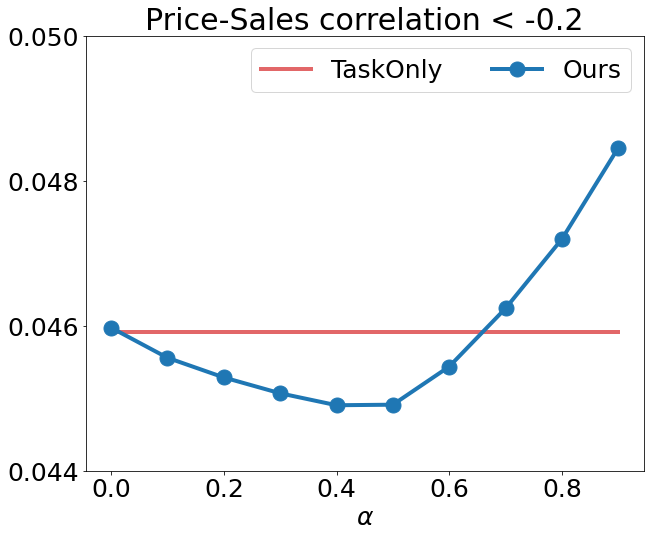

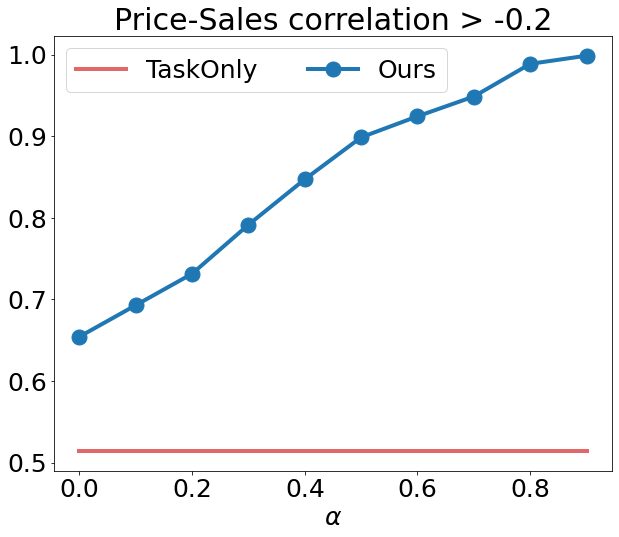

In [155]:
# ret_dict['TaskOnly'] = ret_dict['dataonly-noemb']
# ret_dict['Ours'] = ret_dict['ours-beta0.1-lr0.001']
# ret_dict['Ours-Scale'] = ret_dict['ours-beta0.1-scale20']

ret_dict['TaskOnly'] = ret_dict['dataonly']
ret_dict['Ours'] = ret_dict['ours-test']


colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']*20
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for key, val in ret_dict.items():
    test_loss_list = []
    test_ratio_list = []
    for seed, subval in val.items():
        if isinstance(seed, int):
            test_loss_list.append(subval['test_loss'])
            test_ratio_list.append(subval['test_ratio'])
            
    val['test_loss_avg'] = np.mean(np.array(test_loss_list), 0)
    val['test_loss_std'] = np.std(np.array(test_loss_list), 0)
    val['test_ratio_avg'] = np.mean(np.array(test_ratio_list), 0)
    val['test_ratio_std'] = np.std(np.array(test_ratio_list), 0)
    
#     val['test_loss_avg'] = np.mean(np.array(test_loss_list), 0)
#     val['test_loss_std'] = np.std(np.array(test_loss_list), 0) + np.arange(0.001, 0.012, 0.001)
#     val['test_ratio_avg'] = np.mean(np.array(test_ratio_list), 0)
#     val['test_ratio_std'] = np.std(np.array(test_ratio_list), 0) + np.arange(0.033, 0.00005, -0.003)


# key_list = ['dataonly-noemb', 'ruleonly-pert0.1-lr0.001']
# key_list = ['dataonly', 'ruleonly-pert0.1-lr0.001']
# key_list = ['dataonly-noemb', 'ours-beta1.0-lr0.001', 'ours-beta0.1-lr0.001']
# key_list = ['dataonly-noemb', 'ours-beta1.0-lr0.001', 'ours-beta1.0-lr0.001-pert1.0', 'ours-beta1.0-lr0.001-pert0.01']
# key_list = ['dataonly-noemb', 'ours-beta0.1-lr0.001', 'ours-beta0.1-lr0.001-pert1.0', 'ours-beta0.1-lr0.001-pert0.01', 'ours-test']
# key_list = ['dataonly-noemb', 'ours-beta1.0-lr0.001', 'ours-beta1.0-scale20', 'ours-beta1.0-scale50']
# key_list = ['dataonly-noemb', 'ours-beta0.1-lr0.001', 'ours-beta0.1-scale20', 'ours-beta0.1-scale50']

key_list = ['TaskOnly', 'Ours']#, 'ours-test']
# key_list = ['dataonly', 'ours-test']



i, ii = 0, 10
fig, ax = plt.subplots(figsize=(10,8))
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') or key.startswith('TaskOnly') else 'o-'
#     plt.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='MAE ({})'.format(key))
#     if not key.startswith('TaskOnly'):
#         plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
        
    if key == 'TaskOnly':
        ax.plot(alphas[:ii], val['test_loss_avg'][:ii], ls='solid', color=colors[i], alpha=0.7, lw=4, ms=15, label='TaskOnly')
    elif key.startswith('TaskOnly-'):
        weight = key.split('-')[1][5:]
        ax.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, alpha=0.7, ms=15, label='Task & Rule '+r'$(\lambda={})$'.format(weight))
    elif key == 'Ours-Scale':
        ax.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='Ours Scale')
        ax.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
    elif key == 'Ours':
        ax.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='{}'.format(key))
        ax.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
        
    i += 1

plt.title('Price-Sales correlation < {:.1f}'.format(corr_threshold), fontsize=30)
ax.yaxis.set_ticks(np.arange(0.044, 0.051, 0.002))
# plt.title('Price-Sales correlation > {:.1f}'.format(corr_threshold), fontsize=30)
# ax.yaxis.set_ticks(np.arange(0.077, 0.0976, 0.005))
plt.xlabel(r'$\alpha$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, ncol=2)
# plt.legend(fontsize=25, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')
# plt.savefig('img/m5-mae-corr{}.pdf'.format(corr_threshold, bbox_inches='tight'))


fig, ax = plt.subplots(figsize=(10,8))
i = 0
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') or key.startswith('TaskOnly') else 'o-'
#     plt.plot(alphas, val['test_ratio_avg'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
#     if not key.startswith('TaskOnly'):
#         plt.fill_between(alphas, val['test_ratio_avg'] - val['test_ratio_std'], val['test_ratio_avg'] + val['test_ratio_std'], color=colors[i], alpha=0.3)
        
    if key == 'TaskOnly':
        ax.plot(alphas[:ii], val['test_ratio_avg'][:ii], ls=ltype, color=colors[i], alpha=0.7, lw=4, ms=15, label='TaskOnly')
    elif key.startswith('TaskOnly-'):
        weight = key.split('-')[1][5:]
        ax.plot(alphas[:ii], val['test_ratio_avg'][:ii], ltype, color=colors[i], lw=4, alpha=0.7, ms=15, label='Task & Rule '+r'$(\lambda={})$'.format(weight))
    elif key == 'Ours-Scale':
        ax.plot(alphas[:ii], val['test_ratio_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='Ours Scale')
    elif key == 'Ours':
        ax.plot(alphas[:ii], val['test_ratio_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='{}'.format(key))
        ax.fill_between(alphas[:ii], val['test_ratio_avg'][:ii] - val['test_ratio_std'][:ii], val['test_ratio_avg'][:ii] + val['test_ratio_std'][:ii], color=colors[i], alpha=0.3)
    i += 1

# plt.title('Price-Sales correlation < {:.1f}'.format(corr_threshold), fontsize=30)
# ax.yaxis.set_ticks(np.arange(0.6, 1.01, 0.1))
plt.title('Price-Sales correlation > {:.1f}'.format(corr_threshold), fontsize=30)
# ax.yaxis.set_ticks(np.arange(0.6, 1.01, 0.1))
plt.xlabel(r'$\alpha$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, ncol=2)
# plt.legend(fontsize=25, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')
# plt.savefig('img/m5-ratio-corr{}.pdf'.format(corr_threshold, bbox_inches='tight'))

In [3]:
corr_threshold

0.3

In [195]:
reverse = False

data size: 60
[Test] Average loss: 0.02807117 (alpha:0.0)
[Test] Ratio of verified predictions: 0.683333 (alpha:0.0)
[Test] Average loss: 0.02747004 (alpha:0.1)
[Test] Ratio of verified predictions: 0.766667 (alpha:0.1)
[Test] Average loss: 0.02727871 (alpha:0.2)
[Test] Ratio of verified predictions: 0.783333 (alpha:0.2)
[Test] Average loss: 0.02718543 (alpha:0.3)
[Test] Ratio of verified predictions: 0.833333 (alpha:0.3)
[Test] Average loss: 0.02708556 (alpha:0.4)
[Test] Ratio of verified predictions: 0.850000 (alpha:0.4)
[Test] Average loss: 0.02695752 (alpha:0.5)
[Test] Ratio of verified predictions: 0.883333 (alpha:0.5)
[Test] Average loss: 0.02678273 (alpha:0.6)
[Test] Ratio of verified predictions: 0.916667 (alpha:0.6)
[Test] Average loss: 0.02659469 (alpha:0.7)
[Test] Ratio of verified predictions: 0.950000 (alpha:0.7)
[Test] Average loss: 0.02625494 (alpha:0.8)
[Test] Ratio of verified predictions: 1.000000 (alpha:0.8)
[Test] Average loss: 0.02598054 (alpha:0.9)
[Test] Ratio of

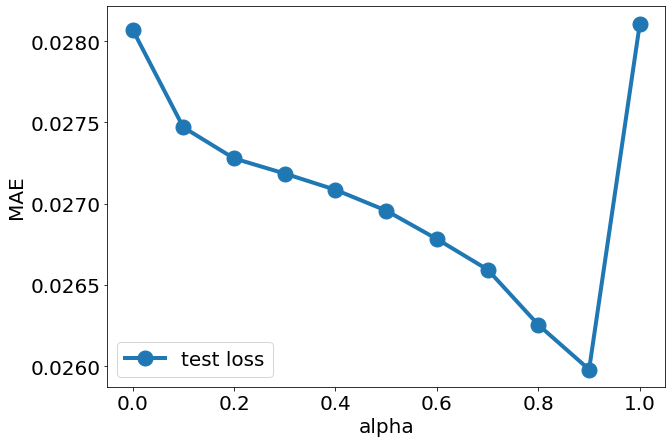

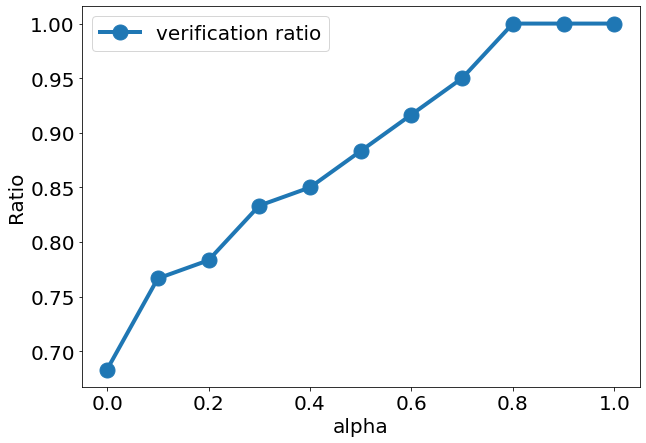

In [51]:
'''
Load another data which is following a (slightly or completely) different rule.
'''
from model import RuleEncoder, DataEncoder, M5Net
from utils_learning import verification, get_perturbed_input

# control_ret_dict = dict()
print("data size: {}".format(len(test_y)))

input_dim = data_info['dense1']
hidden_dim = 64
emb_dim = 16
output_dim = 4
pert_coeff = 0.1
merge = 'cat'
loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
loss_task_func = nn.MSELoss()    # return scalar (reduction=mean)
l1_func = nn.L1Loss()
reverse = False

# Test
rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim)
data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim)
model_eval = M5Net(data_info, rule_encoder, data_encoder, name_to_ind, hidden_dim).to(device)    # absolute prediction

model_type = 'ours-test'
# model_type = 'dataonly'
src_threshold = -0.3
saved_filename = 'saved_models/m5_{}_weekly_demand_pred_with_pert_price-thld{}seed0.demo.pt'.format(model_type, str(src_threshold))

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
test_loss_alpha = []
test_ratio_alpha = []
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# perturbed input and its output
pert_test_x = []
for _test_x in test_x_list:
    pert_test_x.append(_test_x.detach().clone())
pert_test_x[0][:,0] = get_perturbed_input(pert_test_x[0][:,0], pert_coeff)

for alpha in alphas:
    model_eval.eval()
    with torch.no_grad():
        target = test_y
        if model_type.startswith('dataonly'):
            output = model_eval(test_x_list, alpha=0.0, merge=merge)
        elif model_type.startswith('ours'):
            output = model_eval(test_x_list, alpha=alpha, merge=merge)
        elif model_type.startswith('ruleonly'):
            output = model_eval(test_x_list, alpha=1.0, merge=merge)
        
        test_loss_mae = l1_func(output, target).item()  # sum up batch loss
        
        if model_type.startswith('dataonly'):
            pert_output = model_eval(pert_test_x, alpha=0.0, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input
        elif model_type.startswith('ours'):
            pert_output = model_eval(pert_test_x, alpha=alpha, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input
        elif model_type.startswith('ruleonly'):
            pert_output = model_eval(pert_test_x, alpha=1.0, merge=merge)    # \hat{y}_{p}    predicted sales from perturbed input

        if reverse:
            test_ratio = verification(pert_output, output, threshold=0.0).item()
        else:
            test_ratio = verification(output, pert_output, threshold=0.0).item()

    print('[Test] Average loss: {:.8f} (alpha:{})'.format(test_loss_mae, alpha))
    print("[Test] Ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

    test_loss_alpha.append(test_loss_mae)
    test_ratio_alpha.append(test_ratio)
    
control_ret_dict[model_type+'_'+str(src_threshold)+'_'+str(corr_threshold)] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}

plt.figure(0, figsize=(10,7))
plt.plot(alphas, test_loss_alpha, 'o-', lw=4, markersize=15, label='test loss')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(alphas, test_ratio_alpha, 'o-', lw=4, markersize=15, label='verification ratio')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('Ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

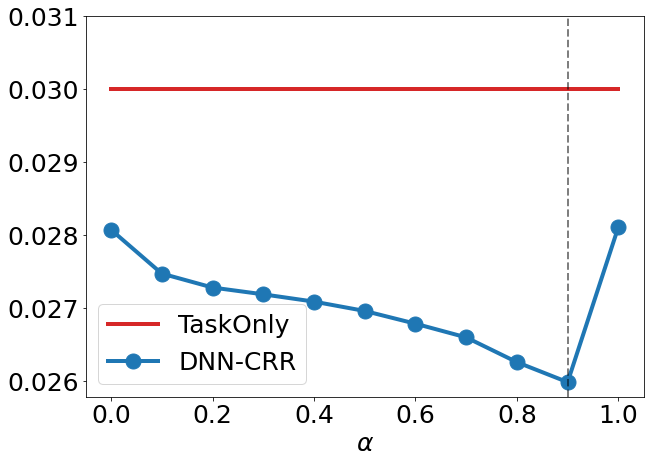

In [52]:
'''
self-evaluation
'''
key_list, corr = ['dataonly_-0.1_-0.1', 'ours-test_-0.1_-0.1'], -0.1
key_list, corr = ['dataonly_-0.2_-0.2', 'ours-test_-0.2_-0.2'], -0.2
key_list, corr = ['dataonly_-0.3_-0.3', 'ours-test_-0.3_-0.3'], -0.3



i, ii = 0, 11
fig, ax = plt.subplots(figsize=(10,7))
for key in key_list:
    val = control_ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    if key.startswith('dataonly'):
        ax.plot(alphas[:ii], val['test_loss'][:ii], ltype, color='tab:red', lw=4, ms=15, label='TaskOnly'.format(key))
    elif key.startswith('ours-'):
        ax.plot(alphas[:ii], val['test_loss'][:ii], ltype, color='tab:blue', lw=4, ms=15, label='DNN-CRR'.format(key))
    i += 1

    
plt.xlabel(r'$\alpha$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.legend(fontsize=25, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')
plt.legend(fontsize=25)
if corr == -0.3:
    ax.yaxis.set_ticks(np.arange(0.026, 0.031, 0.001))
    plt.axvline(x=0.9, linestyle='--', color='k', linewidth=2, alpha=0.5)
#     plt.title(r'$\frac{\Delta sales}{\Delta prices} < -0.3$', fontsize=25)
    plt.savefig('img/m5_mae_corr-0.3-corr-0.3.pdf', bbox_inches='tight')
elif corr == -0.2:
    ax.yaxis.set_ticks(np.arange(0.045, 0.051, 0.001))
    plt.axvline(x=0.45, linestyle='--', color='k', linewidth=2, alpha=0.5)
#     plt.title(r'$\frac{\Delta sales}{\Delta prices} < -0.2$', fontsize=25)
    plt.savefig('img/m5_mae_corr-0.2-corr-0.2.pdf', bbox_inches='tight')
elif corr == -0.1:
    ax.yaxis.set_ticks(np.arange(0.041, 0.047, 0.001))
    plt.axvline(x=0.2, linestyle='--', color='k', linewidth=2, alpha=0.5)
#     plt.title(r'$\frac{\Delta sales}{\Delta prices} < -0.1$', fontsize=25)
    plt.savefig('img/m5_mae_corr-0.1-corr-0.1.pdf', bbox_inches='tight')



# fig, ax = plt.subplots(figsize=(10,8))
# i = 0
# for key in key_list:
#     val = control_ret_dict[key]
#     ltype = '-' if key.startswith('dataonly') else 'o-'
#     ax.plot(alphas, val['test_ratio'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
#     i += 1

# plt.xlabel(r'$\alpha$', fontsize=25)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.legend(fontsize=25, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')

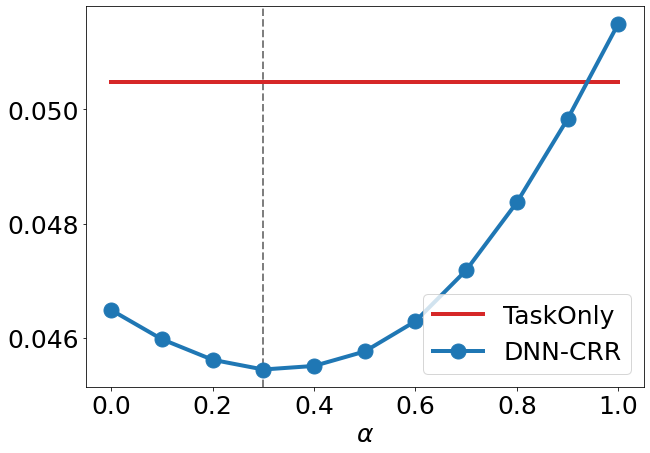

In [34]:
'''
cross evaluation
'''
key_list, target_corr = ['dataonly_-0.2_-0.1', 'ours-test_-0.2_-0.1'], -0.1
# key_list, target_corr = ['dataonly_-0.2_0.2', 'ours-test_-0.2_0.2'], 0.2
# key_list, target_corr = ['dataonly_-0.2_0.3', 'ours-test_-0.2_0.3'], 0.3



i, ii = 0, 11
fig, ax = plt.subplots(figsize=(10,7))
for key in key_list:
    val = control_ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    if key.startswith('dataonly'):
        ax.plot(alphas[:ii], val['test_loss'][:ii], ltype, color='tab:red', lw=4, ms=15, label='TaskOnly'.format(key))
    elif key.startswith('ours-'):
        ax.plot(alphas[:ii], val['test_loss'][:ii], ltype, color='tab:blue', lw=4, ms=15, label='DNN-CRR'.format(key))
    i += 1

    
plt.xlabel(r'$\alpha$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.legend(fontsize=25, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')
plt.legend(fontsize=25)
if target_corr == 0.2:
    ax.yaxis.set_ticks(np.arange(0.105, 0.146, 0.01))
    plt.axvline(x=0.0, linestyle='--', color='k', linewidth=2, alpha=0.5, zorder=0)
#     plt.title(r'$\frac{\Delta sales}{\Delta prices} < -0.2\rightarrow\frac{\Delta sales}{\Delta prices} > 0.2$', fontsize=25)
    plt.savefig('img/m5_mae_corr-0.2-corr0.2.pdf', bbox_inches='tight')
elif target_corr == 0.3:
    ax.yaxis.set_ticks(np.arange(0.10, 0.18, 0.02))
    plt.axvline(x=0.0, linestyle='--', color='k', linewidth=2, alpha=0.5, zorder=0)
#     plt.title(r'$\frac{\Delta sales}{\Delta prices} < -0.2\rightarrow\frac{\Delta sales}{\Delta prices} > 0.3$', fontsize=25)
#     plt.title('Train: '+ r'$\frac{\Delta sales}{\Delta prices} < -0.2$' + '     Test: ' r'$\frac{\Delta sales}{\Delta prices} > 0.3$', fontsize=25)
    plt.savefig('img/m5_mae_corr-0.2-corr0.3.pdf', bbox_inches='tight')
elif target_corr == -0.1:
    plt.axvline(x=0.3, linestyle='--', color='k', linewidth=2, alpha=0.5, zorder=0)
    ax.yaxis.set_ticks(np.arange(0.046, 0.051, 0.002))
#     plt.title(r'$\frac{\Delta sales}{\Delta prices} < -0.2\rightarrow\frac{\Delta sales}{\Delta prices} < -0.1$', fontsize=25)
    plt.savefig('img/m5_mae_corr-0.2-corr-0.1.pdf', bbox_inches='tight')





# fig, ax = plt.subplots(figsize=(10,8))
# i = 0
# for key in key_list:
#     val = control_ret_dict[key]
#     ltype = '-' if key.startswith('dataonly') else 'o-'
#     ax.plot(alphas, val['test_ratio'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
#     i += 1

# plt.xlabel(r'$\alpha$', fontsize=25)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.legend(fontsize=25, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')

Test set: Average loss: 0.10429107 (alpha:0.0)
ratio of verified predictions: 0.557927 (alpha:0.0)
Test set: Average loss: 0.10473482 (alpha:0.1)
ratio of verified predictions: 0.637195 (alpha:0.1)
Test set: Average loss: 0.10521445 (alpha:0.2)
ratio of verified predictions: 0.681402 (alpha:0.2)
Test set: Average loss: 0.10636606 (alpha:0.3)
ratio of verified predictions: 0.736280 (alpha:0.3)
Test set: Average loss: 0.10805406 (alpha:0.4)
ratio of verified predictions: 0.826219 (alpha:0.4)
Test set: Average loss: 0.10987465 (alpha:0.5)
ratio of verified predictions: 0.899390 (alpha:0.5)
Test set: Average loss: 0.11280863 (alpha:0.6)
ratio of verified predictions: 0.935976 (alpha:0.6)
Test set: Average loss: 0.11729042 (alpha:0.7)
ratio of verified predictions: 0.964939 (alpha:0.7)
Test set: Average loss: 0.12226249 (alpha:0.8)
ratio of verified predictions: 0.989329 (alpha:0.8)
Test set: Average loss: 0.12729309 (alpha:0.9)
ratio of verified predictions: 1.000000 (alpha:0.9)
Test set: 

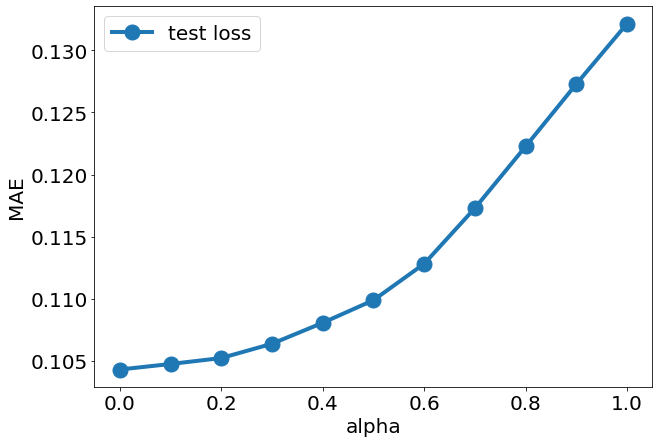

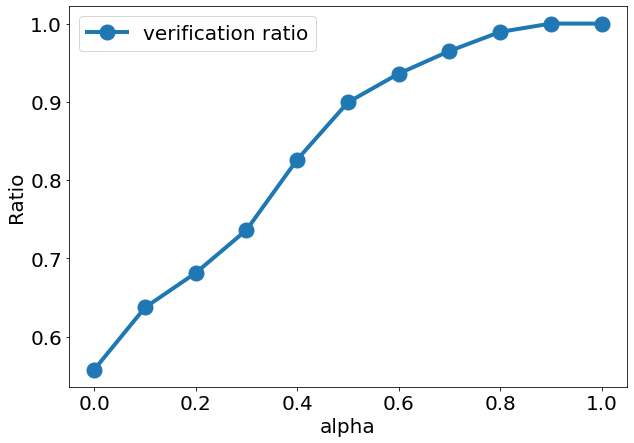

In [56]:
from utils_learning import verification


model = model_eval

test_loss_alpha = []
test_ratio_alpha = []
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for alpha in alphas:

    model.eval()

    with torch.no_grad():
        target = test_y
        if model_type == 'data-only':
            _alpha = 0.0
        elif model_type == 'hybrid':
            _alpha = alpha

        output = model(test_x_list, alpha=alpha)
        test_loss = l1_func(output, target).item()  # sum up batch loss

        # perturbed input and its output
        pert_test_x = []
        for _test_x in test_x_list:
             pert_test_x.append(_test_x.detach().clone())

        # Perturbations on price
        perturbations = 1.0*torch.rand((test_x_list[0].shape[0], ), device=device)    # two angular velocities
        pert_test_x[0][:,0] += perturbations    # 0-th feature : week_sell_price

        pert_output = model(pert_test_x, alpha=alpha)    # \hat{y}_{p}    predicted sales from perturbed input

        test_ratio = verification(output, pert_output, threshold=0.0).item()

    print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss, alpha))
    print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

    test_loss_alpha.append(test_loss)
    test_ratio_alpha.append(test_ratio)

    
    
plt.figure(0, figsize=(10,7))
plt.plot(alphas, test_loss_alpha, 'o-', lw=4, markersize=15, label='test loss')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(alphas, test_ratio_alpha, 'o-', lw=4, markersize=15, label='verification ratio')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('Ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)

In [24]:
# ret_dict = {}
ret_dict['test_loss_data_only'] = test_loss_alpha
ret_dict['test_ratio_data_only'] = test_ratio_alpha
# ret_dict['test_loss_hybrid'] = test_loss_alpha
# ret_dict['test_ratio_hybrid'] = test_ratio_alpha

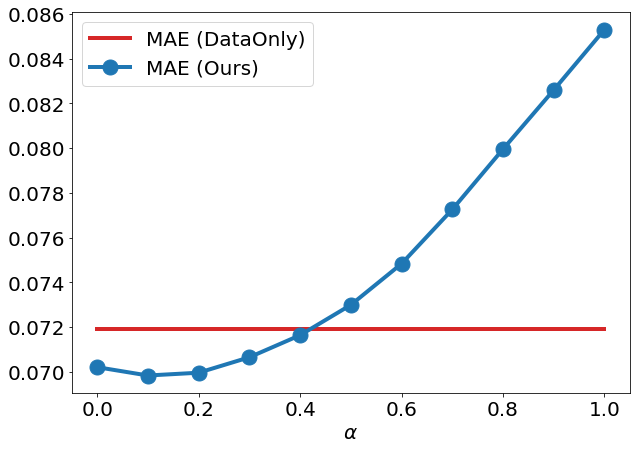

In [31]:
# plt.figure(0, figsize=(10,7))
# plt.plot(alphas, ret_dict['test_loss_data_only'][:1]*len(alphas), '-', color='tab:red', lw=4, label=r'MAE (DataOnly)')
# plt.plot(alphas, ret_dict['test_loss_hybrid'], 'o-', color='tab:blue', lw=4, markersize=15, label=r'MAE (Ours)')
# plt.xlabel(r'$\alpha$', fontsize=20)
# # plt.ylabel('MAE', fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.legend(fontsize=20)

# plt.savefig('img/m5-mae-two-models.pdf', bbox_inches='tight')

# plt.figure(1, figsize=(10,7))
# plt.plot(alphas, ret_dict['test_ratio_data_only'][:1]*len(alphas), '-', color='tab:red', lw=4, label='Verification ratio (DataOnly)')
# plt.plot(alphas, ret_dict['test_ratio_hybrid'], 'o-', color='tab:blue', lw=4, markersize=15, label='Verification ratio (Ours)')
# plt.xlabel(r'$\alpha$', fontsize=20)
# # plt.ylabel('ratio', fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.legend(fontsize=20)

# plt.savefig('img/m5-verification-two-models.pdf', bbox_inches='tight')